<center>
    <h1> Data Mining Techniques </h1>
    <h1> Project 1 </h1>

</center>

<left>
    <h2> Authors </h2>
    <ul>
        <li> 
            <b>Name:</b> Emmanouil Lykos <br />
            <b>ID Number:</b> 1115201600096 <br />
        </li>
        <br />
        <li> 
            <b>Name:</b> Georgios Liakopoulos <br />
            <b>ID Number:</b> 1115201600091 <br />
        </li>
      </ul>
</left>

<h2 align = 'left'> Project Report </h2> <br />
Just importing the necessary libraries for this project.

In [1]:
# General purpose libraries
import os
import numpy as np
from pickle import load,dump

# Used to manipulate the data sets
from pandas import DataFrame, read_csv
import pandas as pd 

# Used for cleaning the dataset from unnecessary words

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import re

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib #only needed to determine Matplotlib version number
import wordcloud
from sklearn.manifold import TSNE  # Used for dimensionality reduction
                                   # at tsne_plot()
    
# Vectorization Libraries

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

######################

# Classification Libarries

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score

##########################
# Enable inline plotting
%matplotlib inline

Function for reading the dictionaries


In [2]:
def readLexica():
    # These variables are holding the words
    # that we read from that dictionary
    
    affin_words = set()
    valence_tweet_words = set()
    generic_words = set()
    nrc_val_words = set()
    nrctag_val_words = set()
    
    # Dictionary with format phrase:valence
    
    affin_weights = {}
    valence_tweet_weights = {}
    generic_weights = {}
    nrc_val_weights = {}
    nrctag_val_weights = {}
    
    # The paths of the dictionaries
    
    filePaths = ['../lexica/affin/affin.txt','../lexica/emotweet/valence_tweet.txt',
    '../lexica/generic/generic.txt','../lexica/nrc/val.txt','../lexica/nrctag/val.txt']

    sets = [affin_words,valence_tweet_words,generic_words,
            nrc_val_words,nrctag_val_words]
    
    weights = [affin_weights,valence_tweet_weights,generic_weights,
            nrc_val_weights,nrctag_val_weights]

    for fileName,set_,weight_dict in zip(filePaths,sets,weights):
        file = open(fileName,'r')

        fileLines = file.readlines()
        
        for line in fileLines:
            # Retrieving the tokens of current line
            linelist = line.split(' ')
            linelist2 = []

            for token in linelist:
                linelist2 += token.split('\t')
            
            linelist = linelist2
            
            # Joining together all the tokens except
            # the last one, because the last token
            # represents the valence of the word/phrase
            
            word = ' '.join(linelist[0:len(linelist)-1])

            if word not in set_:
                set_.add(word)
                weight_dict[word] = float(linelist[len(linelist) - 1])

            file.close()
    
    return tuple(weights)

# Retieving the dictionaries
affin_dict,valence_tweet_dict,generic_dict,nrc_val_dict,nrctag_val_dict = readLexica()
dictionaries = [affin_dict,valence_tweet_dict,nrc_val_dict,nrctag_val_dict]

Reading the training dataset, the test dataset and test gold to get the necessary information

**Note**: We read the tsv files with the hard-coded way because when we called the read_csv function
with separator equal with '\t', not all tweets from the training set file was read. Thus, we prefered
the safe way.

In [3]:
# Setting the necessary paths
train_set_path = '../twitter_data/train2017.tsv'
test_set_path  = '../twitter_data/test2017.tsv'
test_set_gold_path  = '../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt'

filesToRead = [train_set_path,test_set_path,test_set_gold_path]
dataframes  = []

for filePath in filesToRead:
    file = open(filePath,"r")

    line = file.readline()
    lines = []

    while len(line) != 0:
        line = line.split("\t")

        line[len(line) - 1] = line[len(line) - 1].replace('\n','')

        if len(line) > 0:
            lines.append(line)

        line = file.readline()

    if filePath != test_set_gold_path:
        curr_df = pd.DataFrame(data = lines,columns = ['ID1','ID2','Tag','Tweet'])
        curr_df = curr_df[['Tag','Tweet']]     # Getting the columns that we care for
        dataframes.append(curr_df)
    else:
        curr_df = pd.DataFrame(data = lines,columns = ['ID1','Tag'])   
        curr_df = curr_df[['Tag']]        # We suppose that original tags are written with the
                                          # same sequence as tweets at file
        dataframes.append(curr_df)

    file.close()

training_dataframe = dataframes[0]
test_dataframe = dataframes[1]
test_solutions = dataframes[2]

#Example
training_dataframe

,Tag,Tweet
0,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,negative,"Theo Walcott is still shit, watch Rafa and Joh..."
2,negative,"its not that I'm a GSP fan, i just hate Nick D..."
3,negative,Iranian general says Israel's Iron Dome can't ...
4,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ti..."
5,neutral,I sat through this whole movie just for Harry ...
6,positive,with J Davlar 11th. Main rivals are team Polan...
7,negative,"Talking about ACT's && SAT's, deciding where I..."
8,neutral,"Why is \""""Happy Valentines Day\"""" trending? It..."
9,negative,"They may have a SuperBowl in Dallas, but Dalla..."


Getting the **sentimel tendency** of the tweets of **training** set and printing a bar graph

**Note**: We did that, in this point of the program because clean-up takes time and it's not a graph
that will change after the clean-up, so it is better to be there as an initial statistic/

Positive Tweets Percentage 41.0 percent
Negative Tweets Percentage 16.0 percent
Neutral Tweets Percentage 43.0 percent


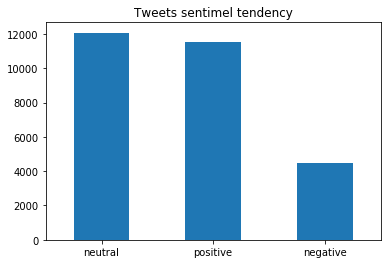

In [ ]:
# Getting a series object which has the number
# of occurences of different value of Tag column

tags = training_dataframe['Tag'].value_counts()

neutral_num = tags['neutral']
positive_num = tags['positive']
negative_num = tags['negative']

print("Positive Tweets Percentage %.1f percent" % ((float(positive_num) / len(training_dataframe))*100))
print("Negative Tweets Percentage %.1f percent" % ((float(negative_num) / len(training_dataframe))*100))
print("Neutral Tweets Percentage %.1f percent" % ((float(neutral_num) / len(training_dataframe))*100))

# Printing the bar plot for tweets

tags.plot.bar(title = 'Tweets sentimel tendency')
plt.xticks(rotation = 0)

plt.show()

From the above graph we can conclude that in the training dataset the tweets have
**neutral** and **positive** inclination, and not **negative** one. Thus, probably
someone must have come to the conclusion that at Twitter most post are **neutral** and
**positive**, because we could see from each **sentimel** percentage that the number
of **positive** tweets are close to the number of **neutral** tweets.

<h3>Data Clean-Up Part</h3>

Part of the program that clean the tweets

In [ ]:
# a list to remove the words such as 1st or 5th , the numbers has been removed earlier
# so the word will be st or th
more_stopwords = ['st','th']

#function to predict if a word is adjective noun verb etc , for lemmatization
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

#function to remove the stopwords from a tweet
def stop_words(stemmer,tweet):

    tweet = [ lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tweet if (word not in stopwords.words('english') 
                                                    and len(word) > 1 and word not in more_stopwords) or word == 'not']
                                                     
    return tweet

In [ ]:
##############################################
# CLEANUP PHASE #

#make every letter of the tweets in lower case
training_dataframe['Tweet'] = training_dataframe.Tweet.apply(lambda t: t.lower())

#remove the tags 
training_dataframe['Tweet'] = training_dataframe.Tweet.apply(lambda t: re.sub("@[a-z!\"$%&\'()*+,-./:;<=>?[\\]^_`{|}~+]+","",t))

#remove the hashtags
training_dataframe['Tweet'] = training_dataframe.Tweet.apply(lambda t: re.sub("#[a-z!\"$%&\'()*+,-./:;<=>?[\\]^_`{|}~+]+","",t))

#remove the links
training_dataframe['Tweet'] = training_dataframe.Tweet.apply(lambda t: re.sub("http[a-z!\"$%&\'()*+,-./:;<=>?[\\]^_`{|}~]+","",t))

#remove every character which is not letter and space
training_dataframe['Tweet'] = training_dataframe.Tweet.apply(lambda t: re.sub(r'[^a-z ]'," ",t))

#tokenize the tweets word by word
training_dataframe['Tweet'] = training_dataframe.Tweet.apply(lambda t: nltk.word_tokenize(t) )

#do lemmatization 
lemmatizer = WordNetLemmatizer()
training_dataframe['Tweet'] = training_dataframe.Tweet.apply(lambda t: ' '.join( stop_words(lemmatizer,t) ))


#do the same as above in the test set

test_dataframe['Tweet'] = test_dataframe.Tweet.apply(lambda t: t.lower())
test_dataframe['Tweet'] = test_dataframe.Tweet.apply(lambda t: re.sub("@[a-z!\"$%&\'()*+,-./:;<=>?[\\]^_`{|}~+]+","",t))

test_dataframe['Tweet'] = test_dataframe.Tweet.apply(lambda t: re.sub("#[a-z!\"$%&\'()*+,-./:;<=>?[\\]^_`{|}~+]+","",t))
test_dataframe['Tweet'] = test_dataframe.Tweet.apply(lambda t: re.sub("http[a-z!\"$%&\'()*+,-./:;<=>?[\\]^_`{|}~]+","",t))
test_dataframe['Tweet'] = test_dataframe.Tweet.apply(lambda t: re.sub(r'[^a-z ]'," ",t))

test_dataframe['Tweet'] = test_dataframe.Tweet.apply(lambda t: nltk.word_tokenize(t) )

lemmatizer = WordNetLemmatizer()
test_dataframe['Tweet'] = test_dataframe.Tweet.apply(lambda t: ' '.join( stop_words(lemmatizer,t) ))


<h3>Statistics Part</h3>

Initially, we will check if the tweets of each category have any critical difference at their cleaned-up tweet length. We did this analysis on the cleaned tweets for two reasons:

<ul>
    <li>When we did that analysis on the initial dataset, without cleaning the tweets, we saw that the average length and the standard deviation of the lengths was the same at the lengths of the tweets of each category.</li>
    <li>The cleaned tweets contain more essential words that the uncleared tweets which contain stopwords or generally words that don't change the sentimel of the tweet.</li>
</ul>

Getting the number of tokens/words of each tweet

In [ ]:
training_dataframe['WordCount'] = training_dataframe.Tweet.apply(lambda t: len(t.split()))

training_dataframe

Plotting **histograns** for each occuring tweet length of **each** category.

In [ ]:
lines = []

for attr in ['positive','negative','neutral']:
    wanted_tweets = training_dataframe[training_dataframe['Tag'] == attr] # Getting the tweets of the current class
    wanted_tweets_count = wanted_tweets['WordCount']                      # Getting their WordCount column
    
    # Getting maximum/minimum/average length and standard deviation
    
    lines.append([max(wanted_tweets_count),min(wanted_tweets_count),
                  sum(wanted_tweets_count)/len(wanted_tweets_count),
                  np.std(wanted_tweets_count)])
    
    wanted_tweets = wanted_tweets.sort_values(by = 'WordCount')
    hist = wanted_tweets['WordCount'].value_counts(sort = False).sort_index()
    hist.plot.bar(title = attr.title() + " tweet no. of words distribution")  # Printing the histogram
    plt.show()

In [ ]:
pd.DataFrame(data = lines,columns = ['Max','Min','Average','Standard Deviation'],
                   index = ['positive','negative','neutral'])

From the graphs and the table above, I can conclude that the tweet length of each category follows something like a normal distribution and the normal distributions of each category have very close average and standard deviation, one another. Consequently, we don't think that taking as an extra feature the length of the tweet will increase our accuracy because the tweets of each category do not have a significant length difference with one another.

Now, we will create word clouds with the most common adjectives and verbs of our all, positive, negative and neutral tweets. We chose to take the adjectives and verbs because we think that these words are the most critical to determine the sentimel of each tweet. Furthermore, when doing the following procedure to collect these words when we get a word that is on a negative or positive tweet we check if the words is at a neutral tweet, and if there is we do not include it on a the list of positive/negative list of adjectives and verbs, because if we do them we will not condlude anything by the word clouds.

In [ ]:
all_adjs_and_verbs = []
all_adjs_and_verbs_pos = []

all_adjs_and_verbs_neutral = []
neutral_adjs_and_verbs = set()

all_adjs_and_verbs_neg = []

# Collecting the necessary words
for tweet,tweet_tag in zip(training_dataframe['Tweet'],training_dataframe['Tag']):
    splitted_tweet = tweet.split(' ')
    splitted_tweet = [word for word in splitted_tweet if len(word) > 1]

    pos_tags = pos_tag(splitted_tweet)
    
    # The word not is like to belong in every class
    for tag in pos_tags:
        if tag[0] == 'not' or ((tag[1][0] == 'J' or tag[1][0] == 'V') and len(tag[0]) > 1):
            all_adjs_and_verbs.append(tag[0])

            if tweet_tag == 'positive':
                if tag[0] == 'not' or (tag[0] not in neutral_adjs_and_verbs):
                    all_adjs_and_verbs_pos.append(tag[0])
            elif tweet_tag == 'negative':
                if tag[0] == 'not' or (tag[0] not in neutral_adjs_and_verbs):
                    all_adjs_and_verbs_neg.append(tag[0])
            else:
                all_adjs_and_verbs_neutral.append(tag[0])
                neutral_adjs_and_verbs.add(tag[0])

Creating the **word clouds**

<h4>All Words<h4>

In [ ]:
all_adjs_and_verbs_text = ' '.join(all_adjs_and_verbs)

cloud = wordcloud.WordCloud().generate(all_adjs_and_verbs_text)

plt.title("All Words")
plt.imshow(cloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()

<h4>Positive Words</h4>

In [ ]:
all_adjs_and_verbs_text = ' '.join(all_adjs_and_verbs_pos)

cloud = wordcloud.WordCloud().generate(all_adjs_and_verbs_text)

plt.title("Positive Words")
plt.imshow(cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

<h4>Negative Words</h4>

In [ ]:
all_adjs_and_verbs_text = ' '.join(all_adjs_and_verbs_neg)

cloud = wordcloud.WordCloud().generate(all_adjs_and_verbs_text)

plt.title("Negative Words")
plt.imshow(cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

<h4>Neutral Words</h4>

In [ ]:
all_adjs_and_verbs_text = ' '.join(all_adjs_and_verbs_neutral)
cloud = wordcloud.WordCloud().generate(all_adjs_and_verbs_text)

plt.title("Neutral Words")
plt.imshow(cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

As we can see from the above wordclouds that the most common words that appear at neutral tweets are kind of identical with the most common words of all tweets, hence, we think it was wise that we deleted the words that appear at neutral tweets from the words that appear on positive or negative tweets because if we didn't probably we would have identical word clouds because the neutral words are the most cmmon thus they will obfuscate the words with true positive or negative meaning.

Moreover, we can see at positive and negative wordclouds that they have as most common words, words that as units have positive and negative meaning, respectively. Consequntly, we can assume at this point that we did a good cleaning on the data.

<h3>Vectorization Part</h3>

<h4>Bag of Words Vectorization</h4>

In [ ]:
# Pretty Simple, just calling the necessary function
# for training and testing set

bow_vectorizer = CountVectorizer(max_features = 1000,stop_words = 'english')

bow_xtrain = bow_vectorizer.fit_transform(training_dataframe['Tweet'])

bow_vectorizer = CountVectorizer(max_features = 1000,stop_words = 'english')

bow_xtest  = bow_vectorizer.fit_transform(test_dataframe['Tweet'])

bow_xtrain.shape

<h4>TF-IDF Vectorization</h4>

In [ ]:
# Simple

tfidf_vectorizer = TfidfVectorizer(max_features = 1000,stop_words = 'english')

tfidf_train = tfidf_vectorizer.fit_transform(training_dataframe['Tweet'])

tfidf_vectorizer = TfidfVectorizer(max_features = 1000,stop_words = 'english')

tfidf_test  = tfidf_vectorizer.fit_transform(test_dataframe['Tweet'])

tfidf_train.shape

<h4>Word2Vec Vectorization</h4>

Training of the Word2Vec models of training and test set

In [ ]:
# Checking if already exists a pickle file for each model
# because the training takes too much time

if not os.path.isfile('./pickle_files/train_w2v_model.pkl'):
    tokenized_tweet = training_dataframe['Tweet'].apply(lambda x: x.split()) # tokenizing 

    model_w2v_train = gensim.models.Word2Vec(
                tokenized_tweet,
                size=500, # desired no. of features/independent variables
                window=5, # context window size
                min_count=2,
                sg = 1, # 1 for skip-gram model
                hs = 0,
                negative = 10, # for negative sampling
                workers= 2, # no.of cores
                seed = 34)
    
    #Training the model
    model_w2v_train.train(tokenized_tweet, total_examples= len(training_dataframe['Tweet']),
                         epochs=20)
    
    # Writing the model to a pickle file
    dump(model_w2v_train,open("./pickle_files/train_w2v_model.pkl","w+b"))
else:
    # If there already exists a pickle file I just load the model
    model_w2v_train = load(open("./pickle_files/train_w2v_model.pkl","rb"))

if not os.path.isfile('./pickle_files/test_w2v_model.pkl'):
    tokenized_tweet = test_dataframe['Tweet'].apply(lambda x: x.split()) # tokenizing 
   
    model_w2v_test = gensim.models.Word2Vec(
                tokenized_tweet,
                size=500, # desired no. of features/independent variables
                window=5, # context window size
                min_count=2,
                sg = 1, # 1 for skip-gram model
                hs = 0,
                negative = 10, # for negative sampling
                workers= 8, # no.of cores
                seed = 34) 
    
    # Training the model
    model_w2v_test.train(tokenized_tweet, total_examples= len(test_dataframe['Tweet']), epochs=20)
    
    # Writing the model to a pickle file
    dump(model_w2v_test,open("./pickle_files/test_w2v_model.pkl","w+b"))
else:
    # If there already exists a pickle file I just load the model
    model_w2v_test = load(open("./pickle_files/test_w2v_model.pkl","rb"))

Checking how good was the resulting training **Word2Vec** model of the training set.

In [ ]:
model_w2v_train.wv.most_similar(positive = "trump")

In [ ]:
model_w2v_train.wv.most_similar(positive = 'mcgregor')

As we can see the model is currently well trained,as we observe that the most similar word of these 2 people is their **first name** and the rest of the most similar words of each name are:

<ul>
    <li>For <b>trump</b> are political terms or the names of other political persons such as bush</li>
    <li>For <b>mcgregor</b> are terms that have to do with UFC/MMA rules or things that are directly relevant with that.Furthermore the people's names that appeared are other fighters that probably have to do with McGregor.</li>

<h4>Tweet Vectorization based on Word2Vec Model</h4>

The tweet vectorization was made as the project description says and we add as extra features, except the average valences of words at each dictionary, the minimum and maximum valence andthe number on positive and negative words of the tweet.

In [ ]:
def W2V_TweetVectorize(tweets,w2v_model):
    vectors = []

    for tweet in tweets:
        vector_words_num = 0
        splitted_tweet = nltk.word_tokenize(tweet)
        vector = np.zeros(w2v_model.wv.vector_size)

        dict_appeared_words_num = [0,0,0,0]
        dict_valence_sum = [0,0,0,0]
        curr_multipliers = [1,1,1,1]

        positive_words_num = 0
        negative_words_num = 0

        min_valence = None
        max_valence = None

        for word in splitted_tweet:
            if word in w2v_model.wv.vocab:
                vector += w2v_model[word]
                vector_words_num += 1
            
            appears_pos = 0
            appears_neg  = 0
            for index in range(0,len(dictionaries)):
                if word in dictionaries[index].keys():
                    dict_appeared_words_num[index] += 1

                    if word != 'not':
                        dict_valence_sum[index] += curr_multipliers[index]*dictionaries[index][word]
                        curr_valence = curr_multipliers[index]*dictionaries[index][word]

                        if dictionaries[index][word] >= 0:
                            if curr_multipliers[index] == 1:
                                appears_pos += 1
                            else:
                                appears_neg += 1
                        else:
                            if curr_multipliers[index] == 1:
                                appears_neg += 1
                            else:
                                appears_pos += 1

                        if min_valence == None or min_valence > curr_valence:
                            min_valence = curr_valence

                        if max_valence == None or max_valence < curr_valence:
                            max_valence = curr_valence
                        
                        curr_multipliers[index] = 1
                    else:
                        dict_valence_sum[index] += dictionaries[index]['not']
                        curr_multipliers[index] = -1
            
            if (appears_pos != 0) or (appears_neg != 0):
                if appears_pos >= appears_neg:
                    positive_words_num += 1
                else:
                    negative_words_num += 1
                        
        for i in range(0,len(dict_appeared_words_num)):
            if dict_appeared_words_num[i] == 0:
                dict_appeared_words_num[i] = 1
        
        dict_valence_sum = np.array(dict_valence_sum)
        dict_appeared_words_num = np.array(dict_appeared_words_num)

        if vector_words_num == 0:
            vector = vector
        else:
            vector = vector / vector_words_num
        
        vector = np.append(vector,dict_valence_sum / dict_appeared_words_num)
        vector = np.append(vector,[positive_words_num,negative_words_num])

        if min_valence == None:
            min_valence = 0
        
        if max_valence == None:
            max_valence = 0
        
        vector = np.append(vector,[max_valence,min_valence])

        vectors.append(vector)

    return vectors

In [ ]:
if not os.path.isfile('./pickle_files/w2v_train_vectors.pkl'):
    w2v_train_vectors = W2V_TweetVectorize(training_dataframe['Tweet'],model_w2v_train)

    dump(w2v_train_vectors,open("./pickle_files/w2v_train_vectors.pkl","w+b"))
else:
    w2v_train_vectors = load(open("./pickle_files/w2v_train_vectors.pkl","rb"))

if not os.path.isfile('./pickle_files/w2v_test_vectors.pkl'):
    w2v_test_vectors = W2V_TweetVectorize(test_dataframe['Tweet'],model_w2v_test)

    dump(w2v_test_vectors,open("./pickle_files/w2v_test_vectors.pkl","w+b"))
else:
    w2v_test_vectors = load(open("./pickle_files/w2v_test_vectors.pkl","rb"))

<h4>TSNE plot function</h4>

In [ ]:
def tsne_plot(model,words_to_plot):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    for word in list(model.wv.vocab)[0:words_to_plot + 1]:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []

    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16)) 

    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                xy=(x[i], y[i]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')
    
    plt.show()

    return

Calling the above function

In [ ]:
words_num_to_plot = 500
tsne_plot(model_w2v_train,words_num_to_plot)

<h3>Classification Part</h3>

<h4>Support Vector Machines Classifier</h4>

In [ ]:
def SVM_Classifier(train_vectors,train_labels,test_vectors,test_labels,vec_mode):
    xtrain, xvalid, ytrain, yvalid = train_test_split(train_vectors, 
                                        train_labels,
                                        random_state=42, test_size=0.2)
    
    # We need the vec_mode to configure the name of the .pkl files
    train_split_model_path = './pickle_files/SVM_train_split_' + vec_mode + '.pkl'
    train_full_model_path  = './pickle_files/SVM_train_full_' + vec_mode + '.pkl'

    if not os.path.isfile(train_split_model_path):
        svc = svm.SVC(kernel='linear', C=1, probability=True)
        svc = svc.fit(xtrain, ytrain) # xtrain:bag of words features for train data, ytrain: train data labels

        dump(svc,open(train_split_model_path,'w+b'))
    else:
        svc = load(open(train_split_model_path,'rb'))
    
    prediction = svc.predict(xvalid) #predict on the validation set
    
    # Getting the F1 Score of the cross validation
    F1_Score_split = f1_score(yvalid,prediction,average = 'micro') #evaluate on the validation set

    if not os.path.isfile(train_full_model_path):
        svc = svm.SVC(kernel='linear', C=1, probability=True)
        svc = svc.fit(train_vectors,train_labels)

        dump(svc,open(train_full_model_path,'w+b'))
    else:
        svc = load(open(train_full_model_path,'rb'))
    
    prediction = svc.predict(test_vectors)
    
    # Getting the F1 Score of test set prediction
    F1_Score = f1_score(test_labels,prediction,average = 'micro')

    return (F1_Score_split,F1_Score)

Calling the function of the SVM Classifier and getting the final results

In [ ]:
print(SVM_Classifier(bow_xtrain,training_dataframe['Tag'],
                     bow_xtest,test_solutions['Tag'],'bow'))

print(SVM_Classifier(tfidf_train,training_dataframe['Tag'],
                     tfidf_test,test_solutions['Tag'],'tfidf'))
print(SVM_Classifier(w2v_train_vectors,training_dataframe['Tag'],
                     w2v_test_vectors,test_solutions['Tag'],'w2v'))

<h4>K-Nearest Neighbors Classifier</h4>

In [ ]:
def KNN_Classifier(train_vectors,train_labels,test_vectors,test_labels):
    xtrain, xvalid, ytrain, yvalid = train_test_split(train_vectors, 
                                        train_labels,
                                        random_state=42, test_size=0.2)   

    knn_classifier = KNeighborsClassifier(n_neighbors = 10)

    knn_classifier = knn_classifier.fit(xtrain,ytrain)
    prediction = knn_classifier.predict(xvalid)

    F1_Score_split = f1_score(yvalid,prediction,average = 'micro')

    knn_classifier = knn_classifier.fit(train_vectors,train_labels)
    prediction = knn_classifier.predict(test_vectors)

    F1_Score = f1_score(test_labels,prediction,average = 'micro')

    return (F1_Score_split,F1_Score)

Calling the function of the KNN Classifier and getting the final results

In [ ]:
print(KNN_Classifier(bow_xtrain,training_dataframe['Tag'],
                     bow_xtest,test_solutions['Tag']))

print(KNN_Classifier(tfidf_train,training_dataframe['Tag'],
                     tfidf_test,test_solutions['Tag']))

print(KNN_Classifier(w2v_train_vectors,training_dataframe['Tag'],
                     w2v_test_vectors,test_solutions['Tag']))